In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None) # To display all columns
import matplotlib.pyplot as plt 
%matplotlib inline 
import folium 
from folium import plugins
import house_cluster as hc

In [2]:
data = pd.read_csv("../Data/house_crime_data.csv", parse_dates = ['date'])
data['zipcode'] = data['zipcode'].astype(str)
data.head(2)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Unnamed: 0.1,number of crimes,Assault,Breaking & Entering,Drugs,Property Crime,Robbery,Theft,Theft from Vehicle,Theft of Vehicle
0,0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,408,32.0,131.0,11.0,85.0,6.0,39.0,54.0,50.0
1,1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,15,1.0,2.0,5.0,2.0,0.0,2.0,3.0,0.0


In [3]:
crime_data = pd.read_csv('../Data/cleaned_crime_data.csv', parse_dates=['incident_datetime'])
crime_data.head(2)

,Unnamed: 0,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
0,232,46855834,-1074640623,2010-03-29,Property Crime,NaN,NaN,7900 Block S 115 ST,NaN,SEATTLE,WA,null,null,47.500626,-122.234039,09/25/2010 04:55:52 PM,10/24/2010 10:39:39 PM,POINT (-122.234039 47.500626),0,Monday,Property Crime
1,419,751287106,584277381,2012-07-26,Property Crime,"Time_00:01:00 Case_C16010785 Crime_FRAUD, ALL ...",NaN,10700 Block 21 AV SW,NaN,SEATTLE,WA,98146,NaN,47.507084,-122.360423,03/02/2016 04:03:43 AM,03/14/2016 05:30:39 AM,POINT (-122.3604234 47.5070838),0,Thursday,Property Crime


In [4]:
zipcode_data = data.groupby('zipcode').mean()
zipcode_data['count'] = data.groupby('zipcode').count()['id']
zipcode_data.reset_index(inplace=True)
zipcode_data.head(2)

,zipcode,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Unnamed: 0.1,number of crimes,Assault,Breaking & Entering,Drugs,Property Crime,Robbery,Theft,Theft from Vehicle,Theft of Vehicle,count
0,98001,11591.154891,4.645665e+09,279582.603261,3.366848,2.004755,1892.201087,14939.116848,1.425272,0.0,0.100543,3.347826,7.296196,1715.597826,176.603261,1980.331522,43.086957,47.309010,-122.270777,1824.635870,11250.543478,11394.796196,585.524457,41.173913,150.592391,11.309783,135.146739,6.790761,80.179348,112.105978,48.225543,368
1,98002,11487.246305,4.769607e+09,234165.137931,3.349754,1.842365,1628.379310,7533.906404,1.337438,0.0,0.009852,3.729064,6.689655,1525.246305,103.133005,1967.926108,58.709360,47.308759,-122.213429,1480.133005,7581.197044,11292.024631,31.039409,2.931034,6.088670,1.315271,7.231527,0.137931,4.285714,6.847291,2.201970,203


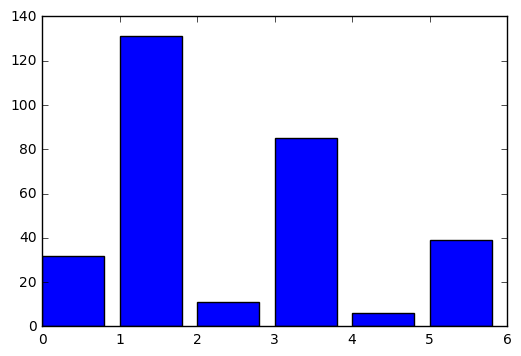

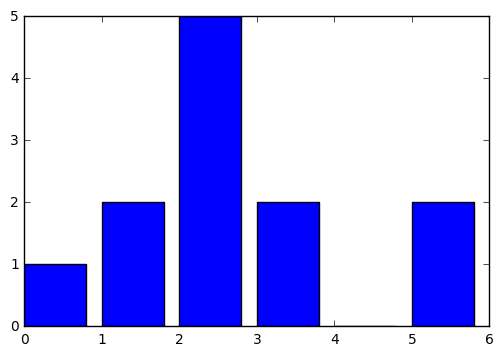

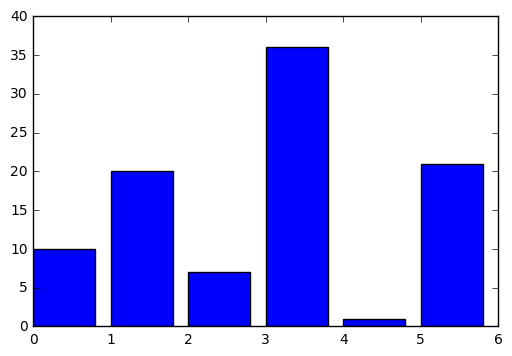

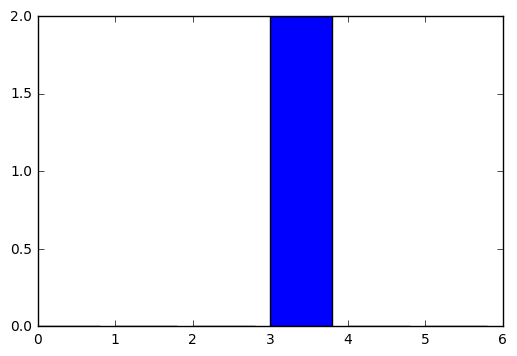

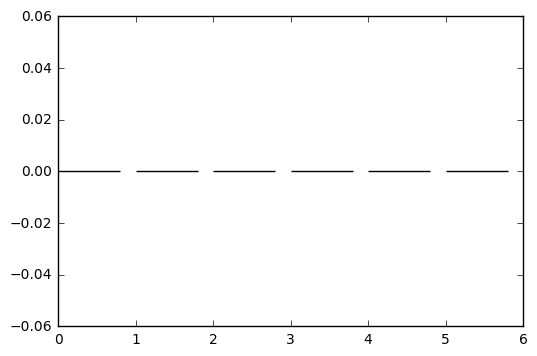

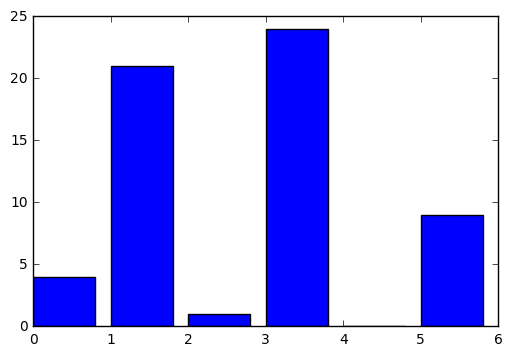

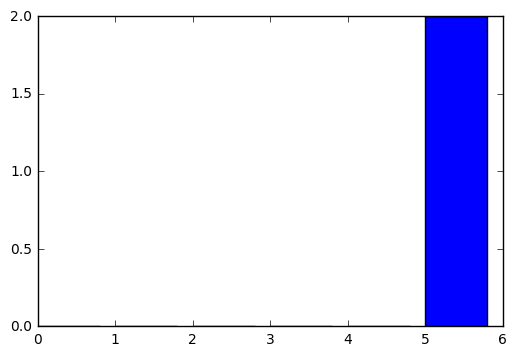

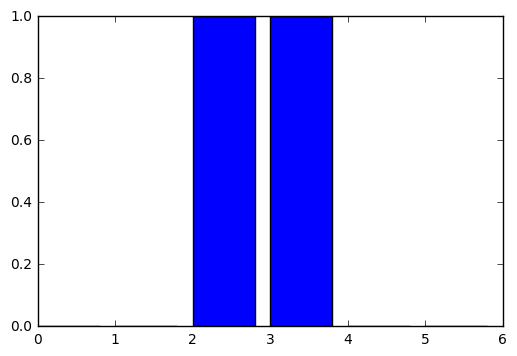

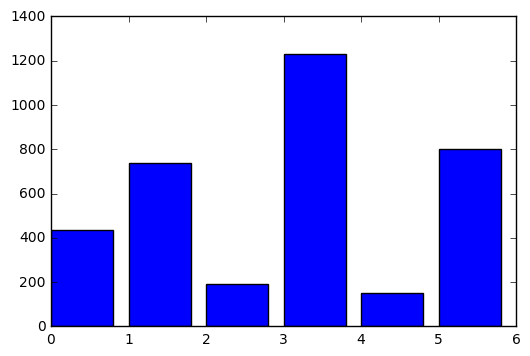

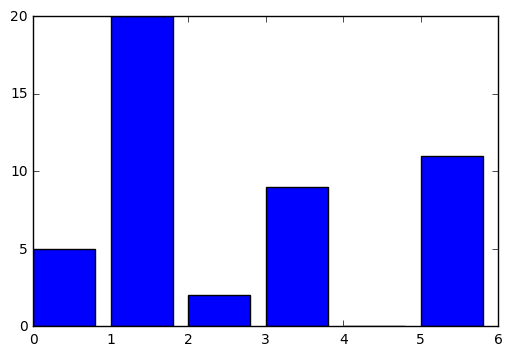

In [6]:
# Generate base map layer
geo_path = '../Data/zipcode_king_county.geojson'
Map = folium.Map(location=[data['lat'].mean(), data['long'].mean()], zoom_start=11, API_key='zipcode')
# Generate marker map layer
MAX_SHOW =10
marker_cluster = folium.MarkerCluster(name = 'House Cluster').add_to(Map)
for iters, row in data[0:MAX_SHOW].iterrows():
    folium.Marker([row["lat"], row["long"]], 
            popup=hc.popup_text(iters, row)).add_to(marker_cluster)

# Generate zipcode vs. house price layer
Map.choropleth(geo_path=geo_path, data=zipcode_data, 
                       columns = ['zipcode', 'price'], key_on = 'feature.properties.ZCTA5CE10',
                     fill_color='OrRd', fill_opacity=0.6, line_opacity=0.2, 
                   legend_name='House Price', name = 'Zipcode vs. House Price', highlight=True)    

# Generate Crime heatmap
Map.add_children(
            plugins.HeatMap([[row["latitude"], row["longitude"]] 
                             for iters, row in crime_data.iterrows()], 
                            name='Crime Incidence', min_opacity=0.5, max_zoom=18, radius = 11))
    


folium.LayerControl().add_to(Map)
Map.save('Map.html')